In [1]:
!pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\THUNDER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [28]:
#Imports & Libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool



In [29]:
# === 1. Load Dataset ===
DATA_PATH = "C:/Users/THUNDER/Desktop/PROJECT/Temporary/filled_temp_dataset.csv"  # Use the drop-cols variant with 14k records
df = pd.read_csv(DATA_PATH, parse_dates=["DATE"])
df = df.sort_values("DATE")
df = df.dropna()  # ensure no missing values in records 


In [30]:
# === 2. Feature Scaling ===
features = [c for c in df.columns if c not in ["DATE", "recession"]]

# Step 1: Ensure all feature columns are numeric
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# Step 2: Drop rows that failed numeric conversion
df = df.dropna()

# Step 3: Scale the cleaned numeric data
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

import joblib
joblib.dump(scaler, "scaler_tgnn.pkl")



['scaler_tgnn.pkl']

In [5]:
# === 3. Build Graph (static) ===
corr = df[features].corr().values
threshold = 0.1
edges = []
weights = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        if abs(corr[i, j]) > threshold:
            edges.append((i, j))
            weights.append(corr[i, j])
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(weights, dtype=torch.float)

num_nodes = len(features)


In [6]:
# === 4. Apply SMOTE and Prepare GCN Dataset ===
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

X = df[features].values
y = df["recession"].astype(int).values

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstruct a DataFrame for graph construction
df_smote = pd.DataFrame(X_resampled, columns=features)
df_smote["recession"] = y_resampled

print("Balanced class distribution after SMOTE:", Counter(df_smote["recession"]))

# Split into training and test sets
train_df, test_df = train_test_split(df_smote, test_size=0.2, stratify=df_smote["recession"], random_state=42)

# Create GCN-compatible data objects
data_list_train = []
data_list_test = []

for _, row in train_df.iterrows():
    x_t = torch.tensor(row[features].astype(np.float32).values, dtype=torch.float32).view(len(features), 1)
    y_t = torch.tensor(int(row["recession"]), dtype=torch.long)
    data_list_train.append(Data(x=x_t, edge_index=edge_index, edge_weight=edge_weight, y=y_t, num_nodes=num_nodes))

for _, row in test_df.iterrows():
    x_t = torch.tensor(row[features].astype(np.float32).values, dtype=torch.float32).view(len(features), 1)
    y_t = torch.tensor(int(row["recession"]), dtype=torch.long)
    data_list_test.append(Data(x=x_t, edge_index=edge_index, edge_weight=edge_weight, y=y_t, num_nodes=num_nodes))

train_loader = DataLoader(data_list_train, batch_size=32, shuffle=True)
test_loader = DataLoader(data_list_test, batch_size=32)


Balanced class distribution after SMOTE: Counter({0: 12011, 1: 12011})


In [7]:
# === 5. GCN Model ===
class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight, batch):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [8]:

# === Focal Loss Definition ===
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return torch.mean(focal_loss) if self.reduction == 'mean' else focal_loss


In [9]:

# === 6. Train GCN (using Focal Loss) ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn_model = GCNClassifier(1, 64).to(device)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
focal_loss_fn = FocalLoss(alpha=0.75, gamma=2)

def train_gcn():
    gcn_model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = gcn_model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = focal_loss_fn(out, data.y)
        loss.backward()
        optimizer.step()


In [10]:
def test_gcn(loader):
    gcn_model.eval()
    ys, preds, probs = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = gcn_model(data.x, data.edge_index, data.edge_weight, data.batch)
            p = out.argmax(dim=1)
            ys.append(data.y.cpu().numpy())
            preds.append(p.cpu().numpy())
            probs.append(out[:,1].cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)
    y_prob = np.concatenate(probs)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred), roc_auc_score(y_true, y_prob)


GCN Epoch 01 — Acc: 0.7771, F1: 0.7534, AUC: 0.7697
GCN Epoch 02 — Acc: 0.7099, F1: 0.6870, AUC: 0.8505
GCN Epoch 03 — Acc: 0.8044, F1: 0.7966, AUC: 0.9061
GCN Epoch 04 — Acc: 0.7829, F1: 0.7714, AUC: 0.8738
GCN Epoch 05 — Acc: 0.8333, F1: 0.8536, AUC: 0.8573
GCN Epoch 06 — Acc: 0.7985, F1: 0.7917, AUC: 0.9117
GCN Epoch 07 — Acc: 0.8368, F1: 0.8512, AUC: 0.8902
GCN Epoch 08 — Acc: 0.8703, F1: 0.8762, AUC: 0.9181
GCN Epoch 09 — Acc: 0.8231, F1: 0.8060, AUC: 0.9115
GCN Epoch 10 — Acc: 0.8581, F1: 0.8656, AUC: 0.9393
GCN Epoch 11 — Acc: 0.8620, F1: 0.8695, AUC: 0.9044
GCN Epoch 12 — Acc: 0.8552, F1: 0.8597, AUC: 0.9350
GCN Epoch 13 — Acc: 0.8166, F1: 0.7948, AUC: 0.9124
GCN Epoch 14 — Acc: 0.8774, F1: 0.8835, AUC: 0.9421
GCN Epoch 15 — Acc: 0.8764, F1: 0.8836, AUC: 0.9505
GCN Epoch 16 — Acc: 0.8780, F1: 0.8826, AUC: 0.9492
GCN Epoch 17 — Acc: 0.8681, F1: 0.8715, AUC: 0.9474
GCN Epoch 18 — Acc: 0.8747, F1: 0.8833, AUC: 0.9443
GCN Epoch 19 — Acc: 0.8266, F1: 0.8500, AUC: 0.9186
GCN Epoch 20

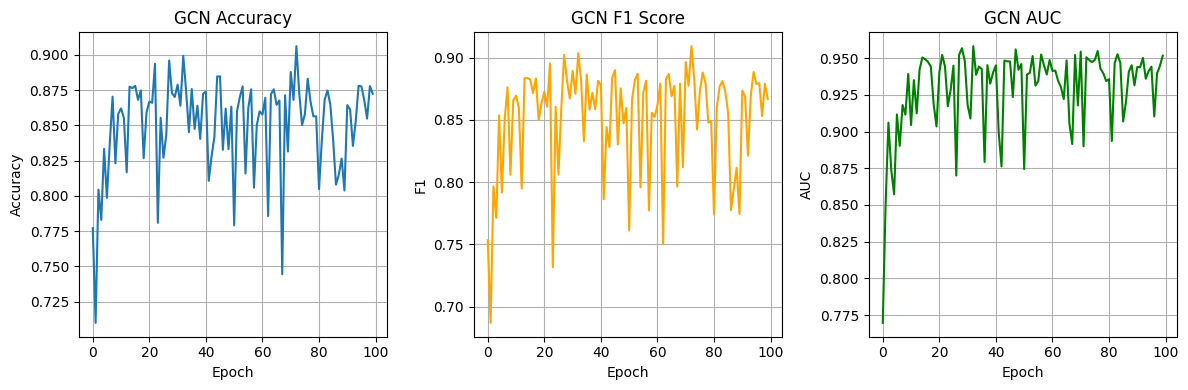

In [11]:
# === Plot GCN Training Metrics ===
import matplotlib.pyplot as plt

gcn_accs, gcn_f1s, gcn_aucs = [], [], []

for epoch in range(1, 101):
    train_gcn()
    acc, f1, auc = test_gcn(test_loader)
    gcn_accs.append(acc)
    gcn_f1s.append(f1)
    gcn_aucs.append(auc)
    print(f"GCN Epoch {epoch:02d} — Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# Final GCN metrics (already last recorded)
acc_gcn, f1_gcn, auc_gcn = gcn_accs[-1], gcn_f1s[-1], gcn_aucs[-1]
print(f"\nFinal GCN — Acc: {acc_gcn:.4f}, F1: {f1_gcn:.4f}, AUC: {auc_gcn:.4f}")

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(gcn_accs, label='Accuracy')
plt.title("GCN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(gcn_f1s, label='F1 Score', color='orange')
plt.title("GCN F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(gcn_aucs, label='ROC AUC', color='green')
plt.title("GCN AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.grid(True)

plt.tight_layout()
plt.show()


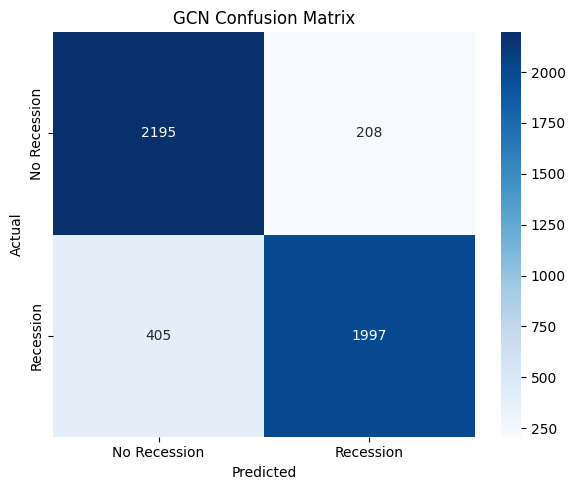


Classification Report:

              precision    recall  f1-score   support

No Recession     0.8442    0.9134    0.8775      2403
   Recession     0.9057    0.8314    0.8669      2402

    accuracy                         0.8724      4805
   macro avg     0.8749    0.8724    0.8722      4805
weighted avg     0.8749    0.8724    0.8722      4805



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict using current model (assumes model is on CUDA)
def get_predictions(loader):
    gcn_model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)  # will stay on CUDA
            out = gcn_model(data.x, data.edge_index, data.edge_weight, data.batch)
            preds = out.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(data.y.cpu())
    return torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()

# Get predictions
y_pred, y_true = get_predictions(test_loader)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Recession", "Recession"],
            yticklabels=["No Recession", "Recession"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GCN Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=4, target_names=["No Recession", "Recession"]))


In [13]:
torch.save(gcn_model.state_dict(), "gcn_model.pth")


In [14]:
# === 7. TGNN Model ===
class TGNN(nn.Module):
    def __init__(self, in_channels, gcn_hidden, gru_hidden, out_channels=2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, gcn_hidden)
        self.conv2 = GCNConv(gcn_hidden, gcn_hidden)
        self.gru = nn.GRU(gcn_hidden, gru_hidden, batch_first=True)
        self.lin = nn.Linear(gru_hidden, out_channels)

    def forward(self, x_seq, edge_index, edge_weight):
        # x_seq: [T, N, in_channels]
        g_seq = []
        for t in range(x_seq.size(0)):
            h = F.relu(self.conv1(x_seq[t], edge_index, edge_weight))
            h = F.dropout(h, p=0.3, training=self.training)
            h = F.relu(self.conv2(h, edge_index, edge_weight))
            g_seq.append(h.mean(dim=0))  # [hidden]
        g_seq = torch.stack(g_seq, dim=0).unsqueeze(0)  # [1, T, hidden]
        out_seq, _ = self.gru(g_seq)  # [1, T, gru_hidden]
        out_seq = out_seq.squeeze(0)  # [T, gru_hidden]
        return self.lin(out_seq)     # [T, 2]



In [16]:
# use SMOTE and Prepare sequence data
x_all = torch.tensor(df_smote[features].values, dtype=torch.float).view(-1, num_nodes, 1).to(device)
y_all = torch.tensor(df_smote["recession"].values, dtype=torch.long).to(device)


# Split mask
idx = np.arange(len(df_smote))  # Use SMOTE-balanced data length
train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=y_all.cpu().numpy(), random_state=42)

train_mask = torch.zeros(len(df_smote), dtype=torch.bool)
test_mask = torch.zeros(len(df_smote), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True


In [17]:
# Initialize TGNN
tgnn_model = TGNN(1, 64, 64).to(device)
optimizer_t = torch.optim.Adam(tgnn_model.parameters(), lr=0.01, weight_decay=5e-4)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = FocalLoss(alpha=0.75, gamma=2)  # Make sure FocalLoss class is already defined



TGNN Epoch 01 — Acc: 0.5222, F1: 0.6763, AUC: 0.5333
TGNN Epoch 02 — Acc: 0.5001, F1: 0.0000, AUC: 0.7207
TGNN Epoch 03 — Acc: 0.5001, F1: 0.0000, AUC: 0.7576
TGNN Epoch 04 — Acc: 0.4999, F1: 0.6666, AUC: 0.8343
TGNN Epoch 05 — Acc: 0.4999, F1: 0.6666, AUC: 0.5653
TGNN Epoch 06 — Acc: 0.4999, F1: 0.6666, AUC: 0.5773
TGNN Epoch 07 — Acc: 0.5180, F1: 0.6742, AUC: 0.7578
TGNN Epoch 08 — Acc: 0.4855, F1: 0.1895, AUC: 0.7548
TGNN Epoch 09 — Acc: 0.4997, F1: 0.0008, AUC: 0.7287
TGNN Epoch 10 — Acc: 0.4995, F1: 0.0000, AUC: 0.7616
TGNN Epoch 11 — Acc: 0.5138, F1: 0.0588, AUC: 0.8570
TGNN Epoch 12 — Acc: 0.7896, F1: 0.7843, AUC: 0.8877
TGNN Epoch 13 — Acc: 0.6450, F1: 0.7339, AUC: 0.8772
TGNN Epoch 14 — Acc: 0.5550, F1: 0.6910, AUC: 0.9153
TGNN Epoch 15 — Acc: 0.6042, F1: 0.7116, AUC: 0.9559
TGNN Epoch 16 — Acc: 0.8310, F1: 0.8525, AUC: 0.9686
TGNN Epoch 17 — Acc: 0.8674, F1: 0.8766, AUC: 0.9667
TGNN Epoch 18 — Acc: 0.8579, F1: 0.8655, AUC: 0.9567
TGNN Epoch 19 — Acc: 0.8568, F1: 0.8638, AUC: 

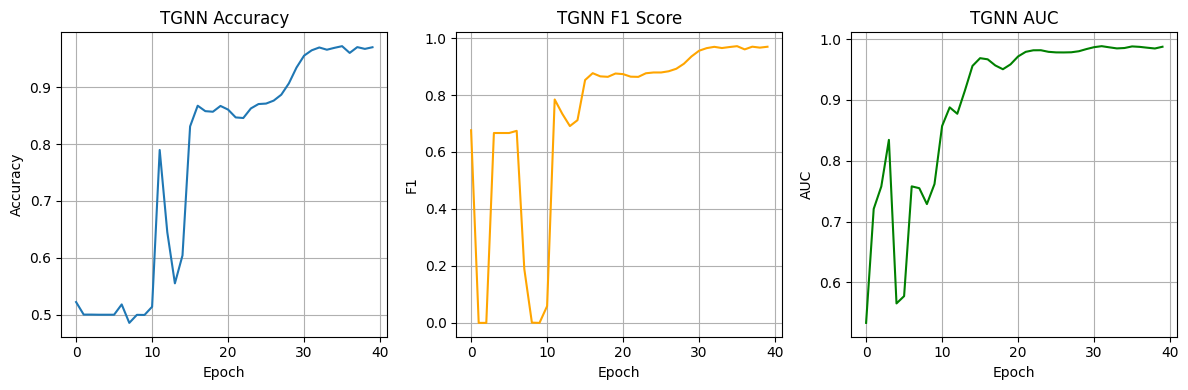

In [18]:

# === Training and Plotting TGNN Metrics ===
tgnn_accs, tgnn_f1s, tgnn_aucs = [], [], []

for epoch in range(1, 41):
    tgnn_model.train()
    optimizer_t.zero_grad()
    out_seq = tgnn_model(x_all, edge_index.to(device), edge_weight.to(device))
    loss = loss_fn(out_seq[train_mask], y_all[train_mask])
    loss.backward()
    optimizer_t.step()

    with torch.no_grad():
        preds = out_seq[test_mask].argmax(dim=1).cpu().numpy()
        probs = out_seq[test_mask][:,1].cpu().numpy()
        y_true = y_all[test_mask].cpu().numpy()
        acc = accuracy_score(y_true, preds)
        f1 = f1_score(y_true, preds)
        auc = roc_auc_score(y_true, probs)

        tgnn_accs.append(acc)
        tgnn_f1s.append(f1)
        tgnn_aucs.append(auc)

        print(f"TGNN Epoch {epoch:02d} — Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(tgnn_accs, label='Accuracy')
plt.title("TGNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(tgnn_f1s, label='F1 Score', color='orange')
plt.title("TGNN F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(tgnn_aucs, label='ROC AUC', color='green')
plt.title("TGNN AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.grid(True)

plt.tight_layout()
plt.show()


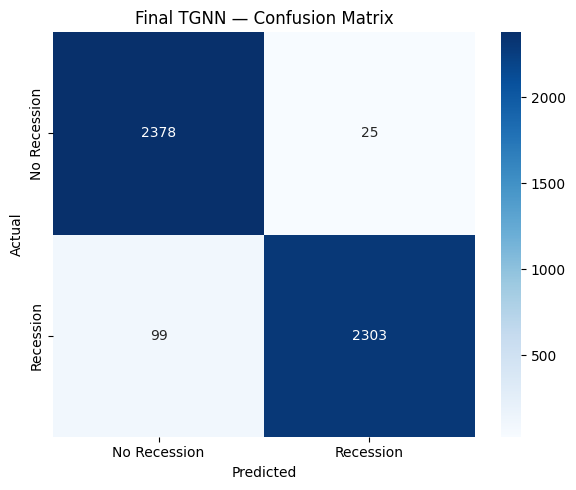


Final TGNN — Classification Report:

              precision    recall  f1-score   support

No Recession     0.9600    0.9896    0.9746      2403
   Recession     0.9893    0.9588    0.9738      2402

    accuracy                         0.9742      4805
   macro avg     0.9746    0.9742    0.9742      4805
weighted avg     0.9746    0.9742    0.9742      4805



In [19]:
# Final TGNN predictions
with torch.no_grad():
    out_seq = tgnn_model(x_all, edge_index.to(device), edge_weight.to(device))
    preds = out_seq[test_mask].argmax(dim=1).cpu().numpy()
    y_true = y_all[test_mask].cpu().numpy()

# Confusion Matrix
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Recession", "Recession"],
            yticklabels=["No Recession", "Recession"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final TGNN — Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification Report
print("\nFinal TGNN — Classification Report:\n")
print(classification_report(y_true, preds, digits=4, target_names=["No Recession", "Recession"]))


In [20]:
torch.save(tgnn_model.state_dict(), "tgnn_model.pth")


In [ ]:
#Interface for predicitons (using TGNN)
import gradio as gr


In [ ]:

# === Preload Model and Scaler ===
scaler = joblib.load("scaler_tgnn.pkl")
tgnn_model.eval()

# Your actual feature list in training order
features_list = [col for col in df.columns if col not in ["DATE", "recession"]]
num_features = len(features_list)

# === Step 1: CSV to Form Fields ===
def parse_csv_input(input_string):
    try:
        values = [float(x.strip()) for x in input_string.split(",")]
        if len(values) != num_features:
            raise ValueError(f"Expected {num_features} values, got {len(values)}")
        return tuple(values)
    except Exception as e:
        return tuple([None] * num_features)

# === Step 2: Prediction ===
def predict_recession(*features):
    raw_input = np.array(features, dtype=np.float32).reshape(1, -1)
    normalized_input = scaler.transform(raw_input)
    input_tensor = torch.tensor(normalized_input.reshape(1, -1, 1), dtype=torch.float32).to(device)

    with torch.no_grad():
        output = tgnn_model(input_tensor, edge_index.to(device), edge_weight.to(device))
        probs = torch.softmax(output[-1], dim=0).cpu().numpy()
        pred_class = int(np.argmax(probs))

    return (
        "Recession" if pred_class == 1 else "No Recession",
        round(probs[1], 4),
        round(probs[0], 4)
    )

# === Build the Interface ===
with gr.Blocks() as demo:
    gr.Markdown("### TGNN Recession Prediction (CSV Autofill + Editable Inputs)")

    with gr.Row():
        csv_input = gr.Textbox(label="Paste comma-separated feature values", placeholder="e.g., 2.3, 4000, 0.9, ...")
        parse_btn = gr.Button("Auto-fill")

    # Editable number fields for each feature
    form_inputs = [gr.Number(label=feat) for feat in features_list]

    with gr.Row():
        predict_btn = gr.Button("Predict")

    prediction = gr.Textbox(label="Prediction")
    prob_recession = gr.Textbox(label="Probability (Recession)")
    prob_no_recession = gr.Textbox(label="Probability (No Recession)")

    # Wire up autofill logic
    parse_btn.click(fn=parse_csv_input, inputs=[csv_input], outputs=form_inputs)

    # Prediction
    predict_btn.click(fn=predict_recession, inputs=form_inputs, outputs=[prediction, prob_recession, prob_no_recession])

# Launch
demo.launch()


Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.36.0, however version 4.44.1 is available, please upgrade.
--------


C:\Users\THUNDER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\THUNDER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\THUNDER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\THUNDER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: User

In [46]:
#Saving necessary files

# Save graph structure
torch.save({
    "edge_index": edge_index,
    "edge_weight": edge_weight
}, "graph_edges.pt")
print("✅ Saved: graph_edges.pt")

# Save feature list
joblib.dump(features, "feature_list.pkl")
print("✅ Saved: feature_list.pkl")



✅ Saved: graph_edges.pt
✅ Saved: feature_list.pkl
